# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — её уже сделали. 

**Этапы:**

* 1 Общая информация о датасете* Путь к файлу: /datasets/users_behavior.csv. Скачать датасет
* 2 Формирование выборок
* 3 Исследование качества разных моделей.
* 4 Проверка качества модели на тестовой выборке.
* 5 Проверка модели на вменяемость.

**Информация о датасете**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Общая информация о датасете

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


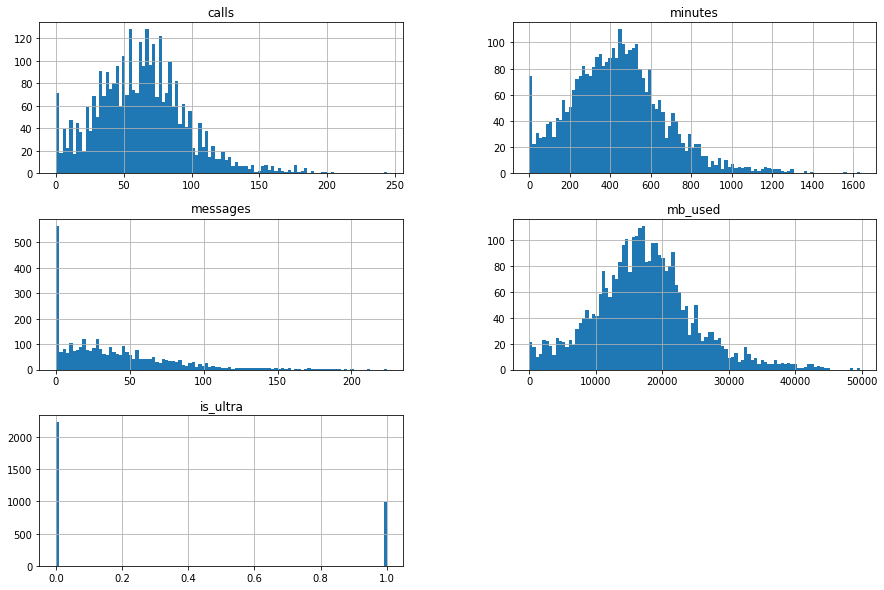

In [4]:
df.hist(figsize=(15,10), bins=100);

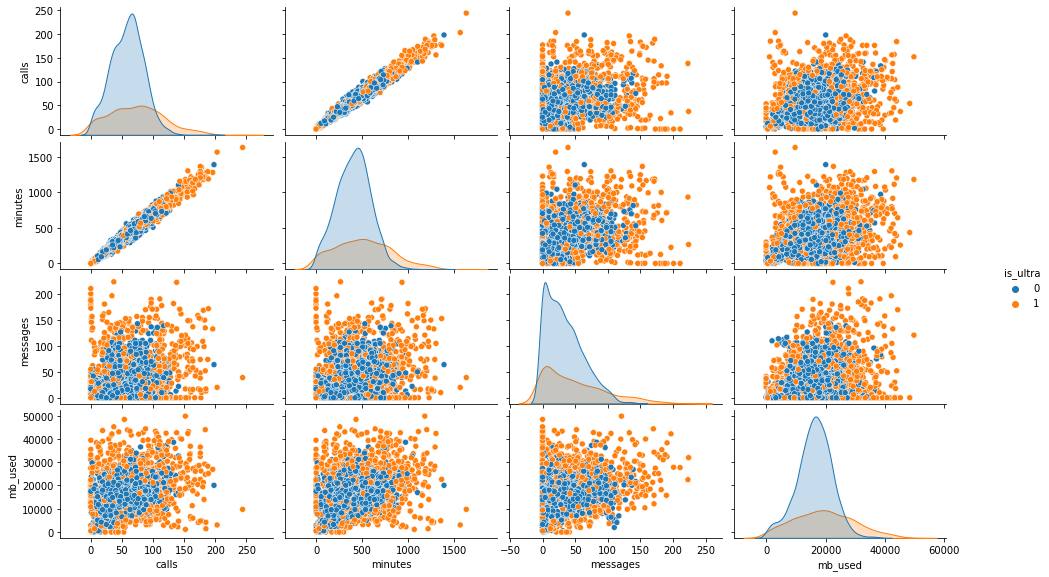

In [5]:
sns.pairplot(df, hue='is_ultra')
plt.gcf().set_size_inches(15,8);

Распределение значений в предсказываемом параметре примерно равное, это позволит не проводить дополнительных манипуляций с разделением выборок

## Формирование выборок

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('is_ultra', axis=1),
                                                    df['is_ultra'],
                                                    test_size=0.2, random_state=12345
                                                   )
x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                    y_train,
                                                    test_size=0.25, random_state=12345
                                                   )
print(y_train.shape, y_valid.shape, y_test.shape, sep='\n')

(1928,)
(643,)
(643,)


Проведено разбиение в формате 3/1/1

## Исследование моделей


### Метод решающего дерева

In [7]:
best_model_tree = None
params_tree = {}
params_tree['accuracy_valid'] = 0

depth_list = list(range(1, 11))
accuracy_score_valid = []
accuracy_score_train = []

for depth in depth_list:
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(x_train, y_train)
    
    result_valid = model.score(x_valid, y_valid)
    accuracy_score_valid.append(result_valid)
    accuracy_score_train.append(model.score(x_train, y_train))
    
    if result_valid > params_tree['accuracy_valid']:
        best_model_tree = model
        params_tree['accuracy_valid'] = result_valid
        params_tree['accuracy_train'] = model.score(x_train, y_train)
        params_tree['depth'] = depth

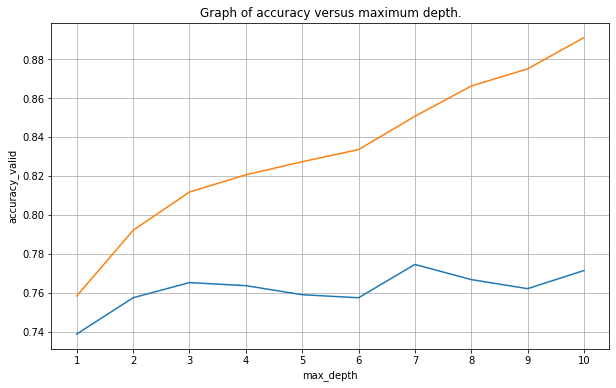

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(depth_list, accuracy_score_valid, depth_list, accuracy_score_train)
plt.xlabel('max_depth')
plt.ylabel('accuracy_valid')
plt.title('Graph of accuracy versus maximum depth.')
plt.grid(True)
plt.xticks(depth_list);

In [9]:
print(*params_tree.items(), sep='\n')

('accuracy_valid', 0.7744945567651633)
('accuracy_train', 0.8506224066390041)
('depth', 7)


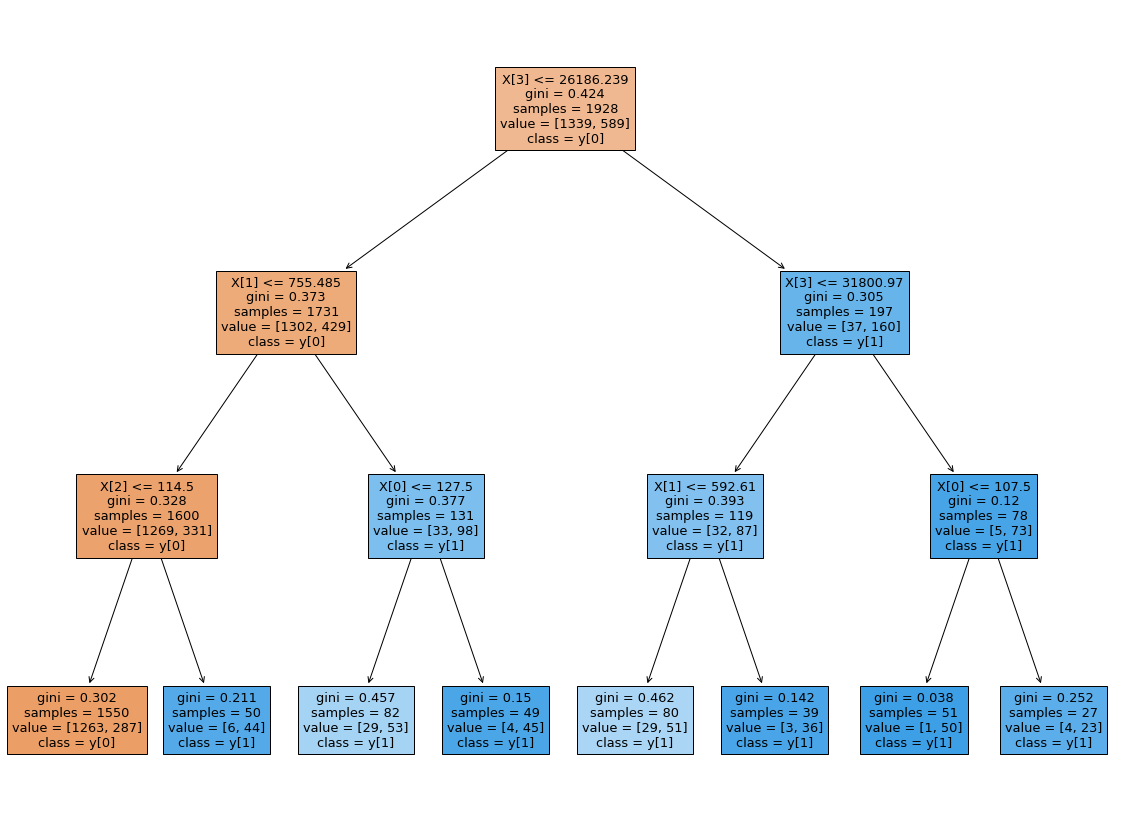

In [10]:
model = DecisionTreeClassifier(random_state=12345, max_depth=3)
model.fit(x_train, y_train)
plt.figure(figsize=(20, 15))
plot_tree(model, filled=True, class_names=True);

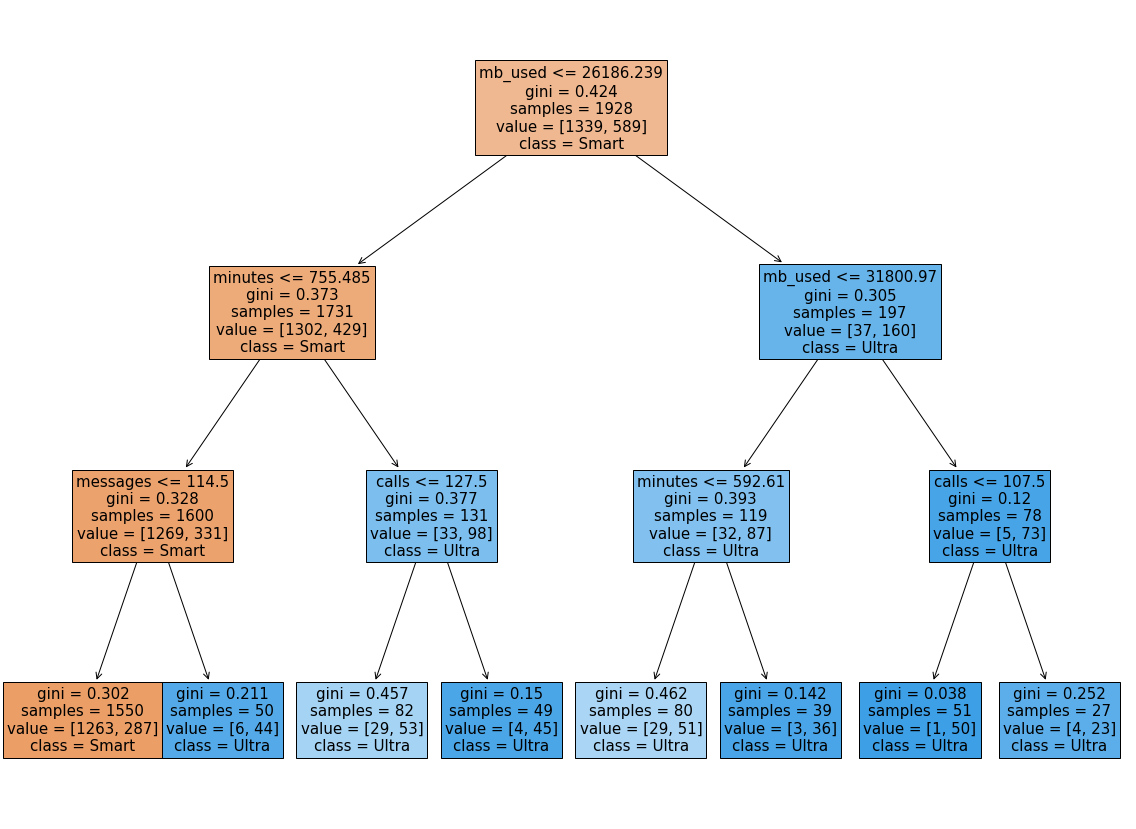

In [11]:
fig = plt.figure(figsize=(20,15))
_ = plot_tree(model, 
               feature_names=df.columns.values, 
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15)

### Метод случайного леса

In [12]:
best_model_forest = None
params_forest = {}
params_forest['accuracy_valid'] = 0

for crit in ['gini', 'entropy']:
    for debth in range(10, 30, 3):
        for est in range(10, 20, 3):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, criterion=crit)
            model.fit(x_train, y_train)

            result_valid = model.score(x_valid, y_valid)

            if result_valid > params_forest['accuracy_valid']:
                best_model_forest = model
                params_forest['accuracy_valid'] = result_valid
                params_forest['accuracy_train'] = model.score(x_train, y_train)
                params_forest['n_estimators'] = est
                params_forest['depth'] = depth
                params_forest['crit'] = crit

In [13]:
print(*params_forest.items(), sep='\n')

('accuracy_valid', 0.7978227060653188)
('accuracy_train', 0.8890041493775933)
('n_estimators', 10)
('depth', 10)
('crit', 'entropy')


### Логистическая регрессия

In [14]:
best_model_logistic = None
params_logistic = {}
params_logistic['accuracy_valid'] = 0

for iterations in [100, 200, 500, 1000]:
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iterations)
    model.fit(x_train, y_train)

    result_valid = model.score(x_valid, y_valid)

    if result_valid > params_logistic['accuracy_valid']:
        best_model_logistic = model
        params_logistic['accuracy_valid'] = result_valid
        params_logistic['accuracy_train'] = model.score(x_train, y_train)
        params_logistic['max_iter'] = iterations

In [15]:
print(*params_logistic.items(), sep='\n')

('accuracy_valid', 0.7262830482115086)
('accuracy_train', 0.7510373443983402)
('max_iter', 100)


Лучшая модель - модель случайного леса с гиперпараметрами `n_estimators` = 16, `max_depth` = 20, `crit` = entropy, значения `accuracy` на валидационной и тренировочной выборке высоки (0.79, 0.98).

## Проверка лучшей модели на тестовой выборке

In [16]:
best_model_forest.score(x_test, y_test)

0.7869362363919129

In [17]:
y_pred = best_model_forest.predict(x_test)
precision_score(y_test, y_pred)

0.7218045112781954

In [18]:
recall_score(y_test, y_pred)

0.4897959183673469

In [19]:
f1_score(y_test, y_pred)

0.5835866261398176

In [20]:
confusion_matrix(y_test, y_pred)

array([[410,  37],
       [100,  96]])

Проверка на тестовой выборке показало значение `accuracy` примерно такое же как и на валидационной

In [21]:
model = RandomForestClassifier(random_state=12345, n_estimators=16, max_depth=20, criterion='entropy')
model.fit(pd.concat((x_train, x_valid)), pd.concat((y_train, y_valid)))
model.score(x_test, y_test)

0.7807153965785381

## Провека модели на адекватность

In [22]:
len(df.query('is_ultra == 0')['is_ultra']) / len(df['is_ultra'])

0.693528313627878

Значение `accuracy` больше чем на модели, которая всегда предсказывает `is_ultra` = 0 значит модель адекватно предсказывает результат

## Вывод

Наилучшей моделью по `accuracy` показала себя модель случайного леса с гиперпараметрами `n_estimators` = 16, `max_depth` = 20, `crit` = entropy, значения `accuracy` на валидационной и тренировочной выборке высоки (0.79, 0.98).